# Test Var(N, m) Relation

In [1]:
from reduction import *
data_maps = {1: image_reduction(1), 2: image_reduction(2)}

In [2]:
from stack import *
inst = 1
filt_order = 3
ifield = 6
sample_type = 'jack_region'
dx = 1200
unmask=True

cbmap, psmap, strmask, strnum, mask_inst1, mask_inst2 = \
load_processed_images(data_maps, return_names=[(inst,ifield,'cbmap'), 
                                    (inst,ifield,'psmap'),
                                   (inst,ifield,'strmask'), 
                                   (inst,ifield,'strnum'),
                                  (1,ifield,'mask_inst'),
                                   (2,ifield,'mask_inst')])
if inst==1:
    mask_inst = mask_inst1
else:
    mask_inst = mask_inst2

cbmap = image_poly_filter(cbmap, strmask*mask_inst, degree=filt_order)

In [93]:
Nsub = 16
# Nsigdata = {}
for im in range(4):
    Nsigdata[im] = {}
    
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]

    stacking_class = stacking(inst, ifield, m_min, m_max, filt_order=filt_order,
                        load_from_file=True, BGsub=False, subsub=True)
    stackdat = stacking_class.stackdat
    cliplim = stacking_class._stackihl_PS_cliplim()

    srctype = 's'
    srcdat = ps_src_select(inst, ifield, m_min, m_max,
        [mask_inst1, mask_inst2], sample_type=sample_type, Nsub=Nsub)

    # start stacking
    rbinedges = stackdat['rbinedges']/0.7 # subpix unit
    rsubbinedges = stackdat['rsubbinedges']/0.7 # subpix unit

    Ilist_dict = {}
    Ilist_dict['Nsrc'] = np.zeros(Nsub)
    start_time = time.time()
    for isub in range(srcdat['Nsub']):
        stackdat['sub'][isub] = {}

        xls = srcdat['sub'][isub]['x' + srctype + '_arr']
        yls = srcdat['sub'][isub]['y' + srctype + '_arr']

        ms = srcdat['sub'][isub]['m' + srctype + '_arr']
        rs = get_mask_radius_th(ifield, ms) # arcsec

        print('stacking %s %d < m < %d, #%d subsample, %d sources, t = %.2f min'\
          %(fieldnamedict[ifield], m_min, m_max,isub,\
           len(xls), (time.time()-start_time)/60))

        Ilist_dict[isub] = []
        for i,(xl,yl,r) in enumerate(zip(xls,yls,rs)):
            cbmapi = cbmap*strmask*mask_inst
            psmapi = psmap*strmask*mask_inst
            maski = strmask*mask_inst
            radmap = make_radius_map(cbmap, xl,yl) # large pix units
            sp1 = np.where((radmap < r/7) & (strnum==1) & (mask_inst==1))
            cbmapi[sp1] = cbmap[sp1]
            psmapi[sp1] = psmap[sp1]
            unmaskpix = np.zeros_like(strmask)
            unmaskpix[sp1] = 1
            maski[sp1] = 1
            if len(sp1[0])>0 and unmask:
                for ibin in [0]:
                    if cliplim['CBmax'][ibin] == np.inf:
                        continue
                    spi = np.where((unmaskpix==1) & \
                                   (radmap*10>=rbinedges[ibin]) & \
                                   (radmap*10 < rbinedges[ibin+1]) & \
                                   (cbmap > cliplim['CBmax'][ibin]))
                    cbmapi[spi] = 0
                    psmapi[spi] = 0
                    maski[spi] = 0
                    spi = np.where((unmaskpix==1) & \
                                   (radmap*10>=rbinedges[ibin]) & \
                                   (radmap*10 < rbinedges[ibin+1]) & \
                                   (cbmap < cliplim['CBmin'][ibin]))
                    cbmapi[spi] = 0
                    psmapi[spi] = 0
                    maski[spi] = 0
                    spi = np.where((unmaskpix==1) & \
                                   (radmap*10>=rbinedges[ibin]) & \
                                   (radmap*10 < rbinedges[ibin+1]) & \
                                   (psmap > cliplim['PSmax'][ibin]))
                    cbmapi[spi] = 0
                    psmapi[spi] = 0
                    maski[spi] = 0
                    spi = np.where((unmaskpix==1) & \
                                   (radmap*10>=rbinedges[ibin]) & \
                                   (radmap*10 < rbinedges[ibin+1]) & \
                                   (psmap < cliplim['PSmin'][ibin]))
                    cbmapi[spi] = 0
                    psmapi[spi] = 0
                    maski[spi] = 0


            # unmask source
            mcb = cbmapi * maski
            mps = psmapi * maski
            xl, yl = int(np.round(xl)), int(np.round(yl))

            if maski[xl,yl]==1:
                Ilist_dict[isub].append(mcb[xl,yl])

        Ilist_dict['Nsrc'][isub] = len(Ilist_dict[isub])

    Nmin = np.min(Ilist_dict['Nsrc'])
    Nsrc_jk_arr = np.arange(Nmin).astype(int)+1
    sigma_arr = np.zeros(len(Nsrc_jk_arr))
    for iNsrc, Nsrc_jk in enumerate(Nsrc_jk_arr):
        Ijk = []
        for isub in range(Nsub):
            Ijk.append(np.mean(Ilist_dict[isub][:Nsrc_jk]))
        sigma_arr[iNsrc] = np.std(Ijk)
        
    Nsigdata[im] = {}
    Nsigdata[im]['N_arr'+srctype] = Nsrc_jk_arr*Nsub
    Nsigdata[im]['sig_arr'+srctype] = sigma_arr
clear_output()

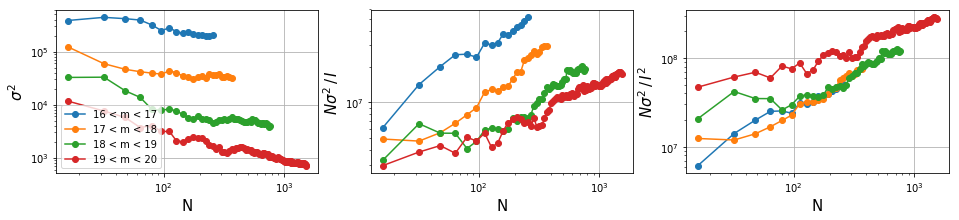

In [120]:
fig, ax = plt.subplots(1, 3, figsize = (16,3))
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    N_arr = Nsigdata[im]['N_arr'+srctype]
    sig_arr = Nsigdata[im]['sig_arr'+srctype]
    I = 10**(-im/2.5)
    ax[0].loglog(N_arr, sig_arr**2,'o-', label='%d < m < %d'%(m_min, m_max))
    ax[1].loglog(N_arr, N_arr*sig_arr**2/I,'o-', label='%d < m < %d'%(m_min, m_max))
    ax[2].loglog(N_arr, N_arr*sig_arr**2/I**2,'o-', label='%d < m < %d'%(m_min, m_max))
ax[0].legend()
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].set_xlabel('N',fontsize=15)
ax[1].set_xlabel('N',fontsize=15)
ax[2].set_xlabel('N',fontsize=15)
ax[0].set_ylabel(r'$\sigma^2$',fontsize=15)
ax[1].set_ylabel(r'$N\sigma^2\,/\,I$',fontsize=15)
ax[2].set_ylabel(r'$N\sigma^2\,/\,I^2$',fontsize=15)
plt.savefig('/Users/ytcheng/Desktop/cov_scale.png', dpi = 150,bbox_inches='tight')

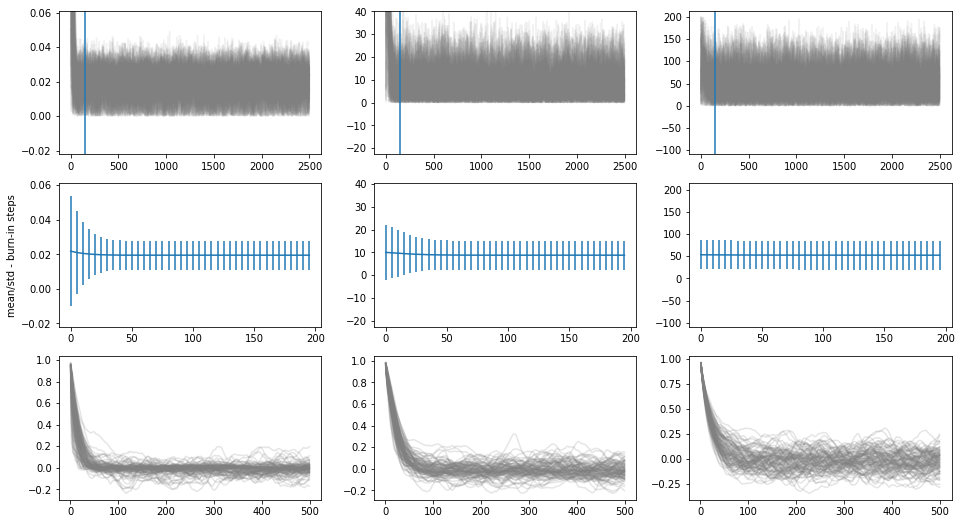

In [166]:
from run_fit import *

inst = 1
ifield = 4
im = 1
Npar = 3
burn_in = 150

#============================================
subsub = True if im==0 else False

R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']

if ifield in [4,5,6,7,8]:
    savename = 'mcmc_'+ str(Npar) + 'par_' + fieldnamedict[ifield] + \
    '_m' + str(magbindict['m_min'][im]) + '_' + str(magbindict['m_max'][im]) + '.npy'
elif ifield is None:
    savename = 'mcmc_3par_joint' + \
    '_m' + str(magbindict['m_min'][im]) + '_' + str(magbindict['m_max'][im]) + '.npy'

if subsub:
    savename = savename[:-4] + '_sub.npy'

chaindir = mypaths['alldat'] + 'TM' + str(inst) + '/'
samples = np.load(chaindir + savename)
flatsamps = samples.copy()
Nsteps, Nwalkers, _ = flatsamps.shape

fig, ax = plt.subplots(3, 3, figsize = (16,9))
for i in range(flatsamps.shape[1]):
    ax[0][0].plot(flatsamps[:,i,0], c='grey', alpha=0.1)
    if Npar==3:
        ax[0][1].plot(flatsamps[:,i,1], c='grey', alpha=0.1)
        ax[0][2].plot(flatsamps[:,i,2], c='grey', alpha=0.1)
        if flatsamps[300,i,1] > 100:
            ax[0][1].plot(flatsamps[:,i,1], c='b', alpha=0.1)
            ax[0][0].plot(flatsamps[:,i,0], c='b', alpha=0.1)
            ax[0][2].plot(flatsamps[:,i,2], c='b', alpha=0.1)
    else:
        ax[0][2].plot(flatsamps[:,i,1], c='grey', alpha=0.1)
        ax[0][1].axis('off')
    
ax[0][0].axvline(burn_in)
ax[0][1].axvline(burn_in)
ax[0][2].axvline(burn_in)

for ipar in range(Npar):
    m = [np.mean(flatsamps[i:,:,ipar]) for i in np.arange(0,200,5)]
    e = [np.std(flatsamps[i:,:,ipar]) for i in np.arange(0,200,5)]
    ax[1][ipar].errorbar(np.arange(0,200,5), m, e)
    ax[0][ipar].set_ylim([m[-1]-5*e[-1], m[-1]+5*e[-1]])
    ax[1][ipar].set_ylim([m[-1]-5*e[-1], m[-1]+5*e[-1]])
    
ax[1][0].set_ylabel('mean/std - burn-in steps')

import pymc3 as pm3
lags=np.arange(1,500)
for i in range(flatsamps.shape[1]):
    autocorr = [pm3.autocorr(flatsamps[burn_in:,i,0], l) for l in lags]
    ax[2][0].plot(lags, autocorr, c='grey',alpha=0.2)
    if Npar==3:
        autocorr = [pm3.autocorr(flatsamps[burn_in:,i,1], l) for l in lags]
        ax[2][1].plot(lags, autocorr, c='grey',alpha=0.2)
        autocorr = [pm3.autocorr(flatsamps[burn_in:,i,2], l) for l in lags]
        ax[2][2].plot(lags, autocorr, c='grey',alpha=0.2)
    else:
        autocorr = [pm3.autocorr(flatsamps[burn_in:,i,1], l) for l in lags]
        ax[2][2].plot(lags, autocorr, c='grey',alpha=0.2)        

In [1]:
from run_fit import *
inst = 1
ifield = 7
im = 3
filt_order = filt_order_dict[inst]
subsub = False

param_fit = fit_stacking_mcmc(inst, ifield, im, filt_order, subsub=subsub)
param_fit.get_profgal_model_interp()

Pre-computing model profiles for interpolation...


In [2]:
R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']
Re2_arr = np.linspace(0.1,3,100)
A2h_arr = np.linspace(0,0.5,100)
chi2_arr = np.zeros([len(Re2_arr),len(A2h_arr)])
for i,Re2 in enumerate(Re2_arr):
    xe2 = Re2 / R200
    for j,A2h in enumerate(A2h_arr):
        chi2 = param_fit.get_chi2(xe2=xe2, A2h=A2h)
        chi2_arr[i,j] = chi2

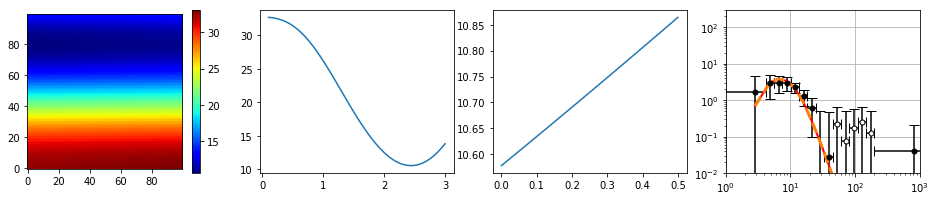

In [3]:
Re2_best_idx, A2h_best_idx = np.where(chi2_arr==np.min(chi2_arr))
Re2_best, A2h_best = Re2_arr[Re2_best_idx], A2h_arr[A2h_best_idx]

fig, ax = plt.subplots(1,4,figsize=(16,3))
imageclip(chi2_arr, ax=ax[0])
ax[1].plot(Re2_arr, chi2_arr[:, A2h_best_idx].flatten())
ax[2].plot(A2h_arr, chi2_arr[Re2_best_idx,:].flatten())

r_arr = param_fit.rsubbins
rbinedges = param_fit.rsubbinedges
profd_arr = param_fit.profex_sub
profd_err = np.sqrt(np.diag(param_fit.covsub))
modelprof = param_fit.get_profexcess_model(Re2=Re2_best, A2h=A2h_best, fast=True)
profex_arr = modelprof['profex_sub']
prof2h_arr = modelprof['prof2h_sub']
profm_arr = profex_arr + prof2h_arr
plot_err_log(r_arr, 
             profd_arr,
             profd_err,
             xedges = rbinedges,
             ax=ax[3], color='k')
ax[3].loglog(r_arr, profm_arr,'r-', lw=2)
ax[3].loglog(r_arr, prof2h_arr,'C2--', lw=3, label=r'$A_{\rm 2h}$ = %.2f'%A2h)
ax[3].loglog(r_arr, profex_arr,'C1--', lw=3, label=r'$R_{e_2}$ = %.2f'%Re2)
ax[3].set_ylim([1e-2,3e2])
ax[3].set_xlim([1e0,1e3])
ax[3].grid()

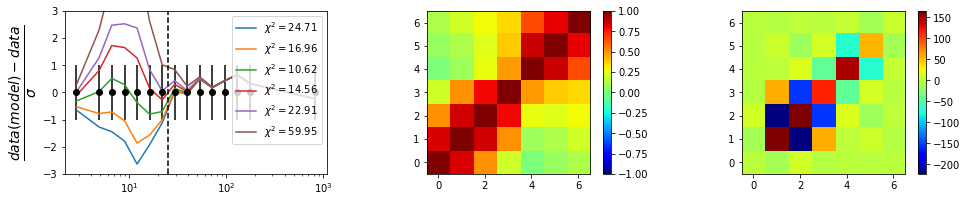

In [4]:
r = param_fit.rsubbins
d = param_fit.profex_sub
e = np.sqrt(np.diag(param_fit.covsub))
Covi = param_fit.covsub_inv
Cov = param_fit.covsub
Cov_norm = normalize_cov(Cov)

fig, ax = plt.subplots(1,3,figsize=(16,3))

for i,scale in enumerate([0.5,0.7,1,1.3,1.5,2]):
    modelprof = param_fit.get_profexcess_model(Re2=Re2_best*scale, A2h=A2h_best, fast=True)
    m = modelprof['profex_sub'] + modelprof['prof2h_sub']
    D = m - d
    D = D[np.newaxis,...]
    chi2_mat = (D.T@D)*Covi
    chi2 = np.sum(chi2_mat)
    
    ax[0].semilogx(r,(m-d)/e,'C'+str(i), label=r'$\chi^2=$%.2f'%(chi2))
ax[0].semilogx(r,(d-d)/e, 'k.')
ax[0].errorbar(r,(d-d)/e, e/e, c='k', fmt='o')
ax[0].set_ylim([-3,3])
ax[0].legend()
ax[0].set_ylabel(r'$\frac{data(model) - data}{\sigma}$', fontsize=20)
ax[0].axvline(np.sqrt(r[6]*r[7]),ls='--',c='k')

imageclip(Cov_norm[:7,:7],vmin=-1,vmax=1, ax=ax[1])
imageclip(chi2_mat[:7,:7], ax=ax[2])

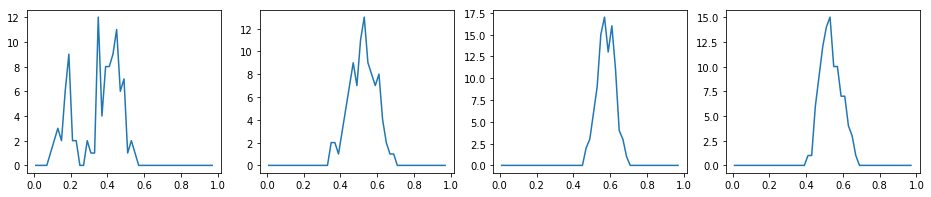

In [169]:
from utils import *
inst = 1
Npar = 3

fig, ax = plt.subplots(1,4,figsize=(16,3))
for ifield in [5]:#[None, 4,5,6,7,8]:
    for im in range(4):
        chains = get_mcmc_chains(inst, im, ifield, Npar=Npar, burn_in = 150)
        burn_in = 150
        ch_acc = chains[burn_in:,:,0]
        acc_rate = np.array([np.sum(ch_acc[1:,i]!=ch_acc[:-1,i])/(ch_acc.shape[0]-1) \
                    for i in range(ch_acc.shape[1])])
        binedges = np.arange(0,1,0.02)
        bins = (binedges[1:] + binedges[:-1]) / 2
        h,_ = np.histogram(acc_rate, bins = binedges)
        ax[im].plot(bins, h)

7 310 227 0.5772811918063314
8 395 482 0.45039908779931587


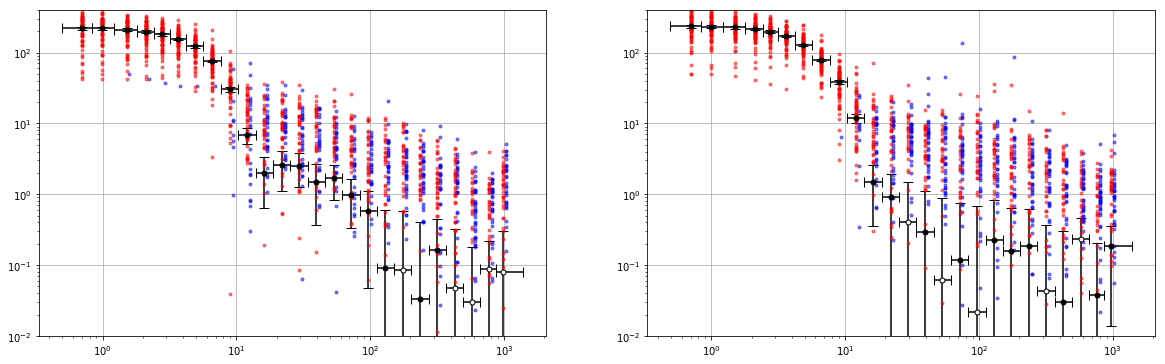

In [107]:
fig, ax = plt.subplots(1, 2, figsize = (20,6))
for i,ifield in enumerate([7,8]):
    Npos, Nneg = 0, 0
    stackdat = stacking(1,ifield, 18,19, filt_order=5,
            load_from_file=True, BGsub=False).stackdat
    plot_err_log(stackdat['rbins'], 
                 stackdat['profcb'],
                 np.sqrt(np.diag(stackdat['cov']['profcb'])),
                 ax=ax[i],color='k',label='Excess')

    for isub in range(64):
        ax[i].loglog(stackdat['rbins'], stackdat['sub'][isub]['profcb'],'.',c='r', alpha=0.5)
        ax[i].loglog(stackdat['rbins']*1.05, -stackdat['sub'][isub]['profcb'],'.',c='b', alpha=0.5)
        
        if stackdat['sub'][isub]['profcb'][14]>=0:
            Npos += stackdat['sub'][isub]['Nsrc']
        else:
            Nneg += stackdat['sub'][isub]['Nsrc']
    print(ifield, Npos, Nneg, Npos/(Npos+Nneg))
    
    ax[i].set_ylim([1e-2,4e2])
    ax[i].grid()